# Общее конфигурирование

In [29]:
from agentslab.utils.device import resolve_device
from pathlib import Path
from agentslab.utils.misc import GeneralConfigs

ENV_ID = "InvertedDoublePendulum-v4"
# ENV_ID = "CartPole-v1"
# ENV_ID = "InvertedPendulum-v5"
# ENV_ID = "Pendulum-v1"

genCfg = GeneralConfigs(
    root = Path('..').resolve(),
    algo_name= "PPO",
    env_id = ENV_ID,
    device = resolve_device("cuda"),
    seed = 42,
    deterministic = True
)

genCfg.device

device(type='cuda')

# Generate Paths, Set Seeds

In [30]:
from agentslab.utils.seeding import set_global_seed
from agentslab.utils.misc import generate_paths, restore_paths

set_global_seed(genCfg.seed, deterministic=genCfg.deterministic)

pathCfg = generate_paths(genCfg.root, genCfg.algo_name, genCfg.env_name)
# pathCfg = restore_paths(genCfg.root, "ppo_InvertedDoublePendulum_20250823_044122")

In [31]:
pathCfg.run_dir

WindowsPath('C:/Users/ordevoir/Documents/GitHub/AgentsLab/runs/PPO_InvertedDoublePendulum-v4_20250825_211355')

# Создание среды

In [32]:
from agentslab.envs.gym_factory import GymEnvConfig, make_gym_env
from torchrl.envs.utils import check_env_specs

env_cfg = GymEnvConfig(
   env_id=ENV_ID, 
   render_mode=None, 
   seed=genCfg.seed
   )

env = make_gym_env(env_cfg)
check_env_specs(env)

# from agentslab.utils.specs import print_specs
# print_specs(env)

2025-08-25 21:13:56,723 [torchrl][INFO]    check_env_specs succeeded! [END]


# Создание актора и критика

In [33]:
from agentslab.modules.networks import MLPConfig, build_mlp
# from agentslab.modules.policy import build_stochastic_actor, is_acts_discrete
from agentslab.modules.policy import build_stochastic_actor, get_num_action_logits, is_acts_discrete
from torchrl.modules import ValueOperator

# Достаём размерности
obs_dim = env.observation_spec["observation"].shape[-1]
act_dim = env.action_spec.shape[-1]

# если действия непрерывные, то число выходов нейросети нужно удвоить:
# coef = 1 if is_acts_discrete(env.action_spec) else 2

num_logits = get_num_action_logits(env.action_spec)
coef = 1 if is_acts_discrete(env.action_spec) else 2  # для Box удваиваем параметры (loc, scale)
out_dim = num_logits * coef

mlp_cfg = MLPConfig(
        in_dim = obs_dim, 
        # out_dim = act_dim * coef,
        out_dim = num_logits * coef,
        hidden_sizes = (256, 256),
        activation = "tanh",
        layer_norm = False
)

actor_network = build_mlp(mlp_cfg)
actor = build_stochastic_actor(actor_network, env.action_spec)

mlp_cfg.out_dim = 1
critic_network = build_mlp(mlp_cfg)
critic = ValueOperator(module=critic_network, in_keys=["observation"])
actor.to(genCfg.device), critic.to(genCfg.device)
obs_dim, act_dim

(11, 1)

# Конфигурирование PPO

In [34]:
from agentslab.runners.trainers import PPOConfigs

ppoCfg = PPOConfigs(
    actor = actor,
    critic = critic,
    gamma = 0.99,
    lmbda = 0.95,
    frames_per_batch = 1000,
    total_frames = 100_000,
    clip_epsilon = 0.2,
    entropy_eps = 1e-4,
    lr = 3e-4,
    critic_coeff = 1.0,
    loss_critic_type = "smooth_l1",
    max_grad_norm = 1.0,
    num_epochs = 10,
    sub_batch_size = 64,
    eval_every = 5,
)

# Loss Function

In [35]:
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
import torch

advantage_module = GAE(
    gamma=ppoCfg.gamma, lmbda=ppoCfg.lmbda, value_network=critic, average_gae=True
)

loss_module = ClipPPOLoss(
    actor_network=actor,
    critic_network=critic,
    clip_epsilon=ppoCfg.clip_epsilon,
    entropy_bonus=bool(ppoCfg.entropy_eps),
    entropy_coeff=ppoCfg.entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coeff=ppoCfg.critic_coeff,
    loss_critic_type=ppoCfg.loss_critic_type,
)

optim = torch.optim.Adam(loss_module.parameters(), ppoCfg.lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optim, 
    T_max=ppoCfg.total_frames // ppoCfg.frames_per_batch, 
    eta_min=0.0
)

# Collector

In [36]:
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

collector = SyncDataCollector(
    create_env_fn=env,
    policy=actor,
    frames_per_batch=ppoCfg.frames_per_batch,
    total_frames=ppoCfg.total_frames,
    split_trajs=False,
    device=genCfg.device,
)
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=ppoCfg.frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

# Checkpointers

In [37]:
from agentslab.utils.checkpointers import CheckpointManager

statefuls = {
    "policy": actor,                # nn.Module
    "optimizer": optim,             # torch.optim.Optimizer
    "scheduler": scheduler,         # lr scheduler
    "replay": replay_buffer,        # TorchRL ReplayBuffer (если используете)
}

chkptr = CheckpointManager(
    ckpt_dir=pathCfg.ckpt_dir,               # .../runs/<run_name>/checkpoints
    statefuls=statefuls,
    meta={"algo": genCfg.algo_name, "env": genCfg.env_id},
    best_metric_key="return_mean",    # по какой метрике выбирать best
    mode="max",                            # "min" для ошибок/лоссов
    max_to_keep=5,
)

# Loggers

In [38]:
from agentslab.utils.loggers import CSVLogger, TBLogger

csv_logger_train = CSVLogger(pathCfg.csv_train)
csv_logger_eval = CSVLogger(pathCfg.csv_eval)
tb_logger_train = TBLogger(pathCfg.tb_train)
tb_logger_eval = TBLogger(pathCfg.tb_eval)

# Training Loop

In [39]:
from agentslab.utils.misc import progress_bar
from agentslab.runners.evals import eval_policy

log_dict = dict()
passed_frames = 0

with progress_bar(ppoCfg.total_frames, desc="PPO") as pbar:
    # --------------------------------------------------------------
    # Итерируемся по коллекторам, пока не наберём нужное число шагов
    for i, tensordict_data in enumerate(collector):
        # Учимся на партии данных
        for _ in range(ppoCfg.num_epochs):
            # Advantage для PPO пересчитываем на каждом проходе
            advantage_module(tensordict_data)
            data_view = tensordict_data.reshape(-1)
            replay_buffer.extend(data_view.cpu())
            for _ in range(ppoCfg.frames_per_batch // ppoCfg.sub_batch_size):
                subdata = replay_buffer.sample(ppoCfg.sub_batch_size)
                loss_vals = loss_module(subdata.to(genCfg.device))
                loss_value = (
                      loss_vals["loss_objective"] 
                    + loss_vals["loss_critic"] 
                    + loss_vals["loss_entropy"]
                )
                # Оптимизация
                loss_value.backward()
                torch.nn.utils.clip_grad_norm_(loss_module.parameters(), ppoCfg.max_grad_norm)
                optim.step()
                optim.zero_grad()
        scheduler.step()            # Шаг LR-планировщика

        # --------------------------------------------------------------

        # Извлекаем метрики
        batch_frames = int(tensordict_data.get(("next", "reward")).numel())
        passed_frames = min(passed_frames + batch_frames, ppoCfg.total_frames)
        log_dict['step'] = passed_frames
        log_dict["reward"] = tensordict_data["next", "reward"].mean().item()
        log_dict["step_count"] = tensordict_data["step_count"].max().item()
        log_dict["lr"] = optim.param_groups[0]["lr"]
        
        # Логгируем метрики
        csv_logger_train.log(log_dict)                          # CSV
        tb_logger_train.log(log_dict, step=log_dict['step'])    # TensorBoard

        # Обновляем описание прогресс-бара
        pbar.set_postfix(
            {"avg_reward": f"{log_dict["reward"]: .4f}",
             "max_step": int(log_dict["step_count"]),
             "lr": f"{log_dict["lr"]: .4e}"},
            refresh=False
        )

        # корректное число фреймов в партии

        if batch_frames > 0:
            remaining = pbar.total - pbar.n
            pbar.update(min(batch_frames, remaining))

        # -----------------------------------------------------------
        # Оценка после каждых eval_every партий
        if (i + 1) % ppoCfg.eval_every == 0:
            eval_results = eval_policy(env, actor, episodes=5, progress=False)
            # pbar.write не ломает отрисовку прогресс-бара
            pbar.write(
                f'eval: avg reward = {eval_results["return_mean"]}, '
                f'max episode lengh = {eval_results["max_episode_lengh"]}'
            )
            eval_results["step"] = log_dict['step']
            csv_logger_eval.log(eval_results)                          # CSV
            tb_logger_eval.log(eval_results, step=log_dict['step'])    # TensorBoard
            chkptr.save(step=log_dict['step'], metrics=eval_results, make_step_snapshot=True)
        

PPO:   0%|          | 0.00/100k [00:00<?, ?frames/s]

eval: avg reward = 163.12967834472656, max episode lengh = 25
eval: avg reward = 215.4019317626953, max episode lengh = 28
eval: avg reward = 244.6862030029297, max episode lengh = 31
eval: avg reward = 411.1042846679687, max episode lengh = 59
eval: avg reward = 675.4295532226563, max episode lengh = 104
eval: avg reward = 494.9046142578125, max episode lengh = 76
eval: avg reward = 862.5423828125, max episode lengh = 116
eval: avg reward = 1092.805615234375, max episode lengh = 167
eval: avg reward = 428.338330078125, max episode lengh = 51
eval: avg reward = 435.8354125976563, max episode lengh = 54
eval: avg reward = 529.0701904296875, max episode lengh = 75
eval: avg reward = 697.7851440429688, max episode lengh = 128
eval: avg reward = 989.1312622070312, max episode lengh = 151
eval: avg reward = 964.75615234375, max episode lengh = 160
eval: avg reward = 811.518212890625, max episode lengh = 158
eval: avg reward = 600.3334777832031, max episode lengh = 120
eval: avg reward = 198

# Graphs

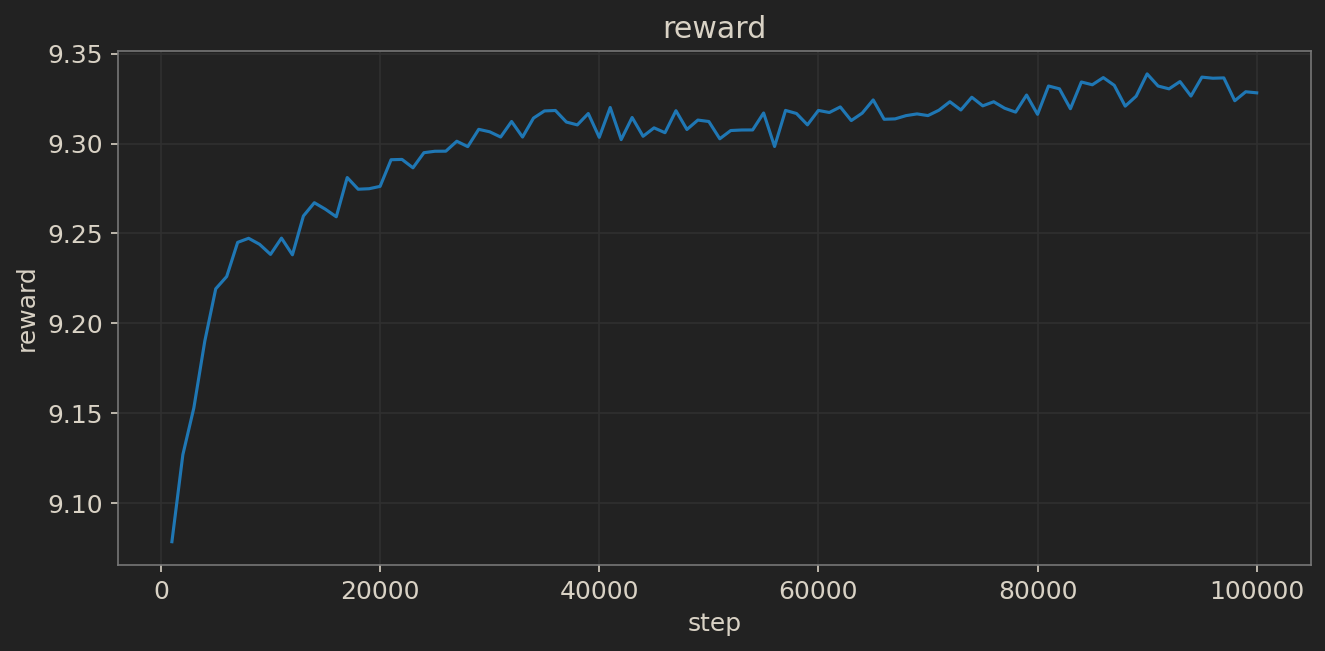

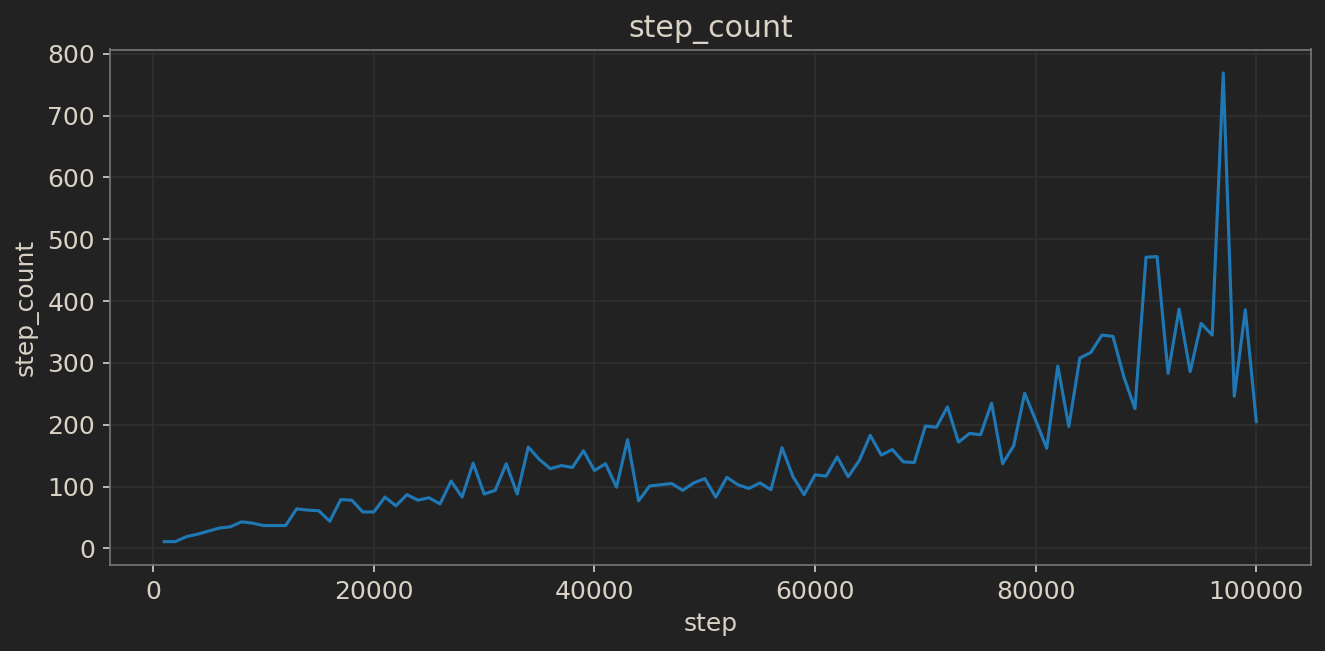

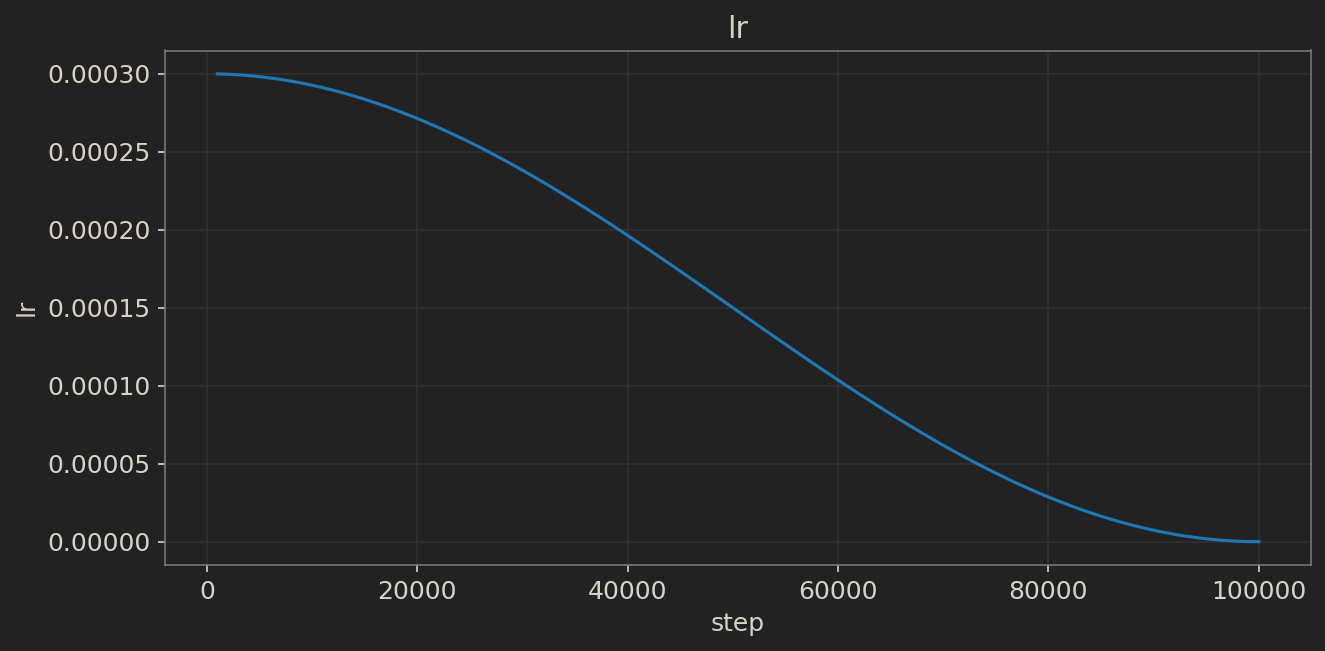

In [40]:
# Чтение последнего train.csv и построение графиков по каждой метрике
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ordevoir-dark")

csv_path = pathCfg.csv_train  # объект paths из вашего кода (RunPaths.csv_train)

# Проверим наличие файла
if not csv_path.exists():
    raise FileNotFoundError(f"train.csv не найден по пути: {csv_path}")

# Читаем CSV (без агрессивных эвристик типов, чтобы избежать предупреждений)
df = pd.read_csv(csv_path, low_memory=False)

# Определим ось X: предпочитаем 'step', затем 'global_step', 'iteration', 'epoch'
x_candidates = [c for c in ["step", "global_step", "iteration", "epoch"] if c in df.columns]
x_col = x_candidates[0] if x_candidates else None

# Выбираем числовые столбцы, исключая ось X
num_cols = df.select_dtypes(include="number").columns.tolist()
if x_col in num_cols:
    num_cols.remove(x_col)

if not num_cols:
    raise ValueError(
        "В train.csv не найдено числовых метрик для построения графиков."
    )

# Строим отдельную диаграмму для каждой метрики
for col in num_cols:
    plt.figure(figsize=(9, 4.5))
    if x_col is not None:
        plt.plot(df[x_col], df[col])
        plt.xlabel(x_col)
    else:
        plt.plot(range(len(df)), df[col])
        plt.xlabel("index")
    plt.ylabel(col)
    plt.title(f"{col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Evaluating

In [41]:
from agentslab.runners.evals import eval_policy

eval_policy(env, actor, episodes=10)

eval:   0%|          | 0/10 [00:00<?, ?it/s]

{'return_mean': 1394.5387420654297,
 'return_sum': 13945.387420654297,
 'max_episode_lengh': 277,
 'num_episodes': 10}

In [42]:
# chkptr.load(pathCfg.ckpt_dir /"step_100000.pt", strict=False, map_location=genCfg.device)
chkptr.load(pathCfg.ckpt_dir / "best.pt", strict=False, map_location=genCfg.device)

In [43]:
import torch
from torchrl.envs.utils import ExplorationType, set_exploration_type

# 1) Среда с human
cfg = GymEnvConfig(
    env_id=ENV_ID,
    render_mode="human",
    seed=genCfg.seed,
)
env = make_gym_env(cfg)

# 2) Актёр в eval
actor.eval()
actor_device = next(actor.parameters()).device  # cuda/cpu

td = env.reset()
done = False
step = 0

try:
    while not done:
        with torch.no_grad(), set_exploration_type(ExplorationType.MODE):
            # ВАЖНО: гоним наблюдения на девайс актёра и возвращаем на девайс env
            td = td.to(actor_device)
            td = actor(td)
            td = td.to(env.device)

        td = env.step(td)
        env.render()  # обновит окно 
        # ! Если заметите двойной перерисовки/дроп FPS — можно убрать явный render()

        term = td.get(("next","terminated"), torch.zeros((), dtype=torch.bool))
        trunc = td.get(("next","truncated"),  torch.zeros((), dtype=torch.bool))
        done = (term | trunc).item()  # для одиночной среды
        print(step)
finally:
    env.close()


RuntimeError: The distribution TanhNormal has not analytical mode. Use ExplorationMode.DETERMINISTIC to get a deterministic sample from it.

In [ ]:
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import torch
from torchrl.envs.utils import ExplorationType, set_exploration_type
from torchrl.envs.utils import step_mdp

cfg = GymEnvConfig(
    env_id=ENV_ID,
    render_mode="rgb_array",  # ключ для инлайн
    seed=genCfg.seed,
)
env = make_gym_env(cfg)

actor.eval()
actor_device = next(actor.parameters()).device

td = env.reset()
done = False

fig, ax = plt.subplots()
im = None
step = 0

try:
    while not done:
        with torch.no_grad(), set_exploration_type(ExplorationType.MODE):
            td = td.to(actor_device)
            td = actor(td)
            td = td.to(env.device)

        td = env.step(td)

        frame = env.render()  # numpy array (H, W, 3)
        if frame is not None:
            if im is None:
                im = ax.imshow(frame)
                ax.set_axis_off()
            else:
                im.set_data(frame)
            display(fig)
            clear_output(wait=True)

        term = td.get(("next","terminated"), torch.zeros((), dtype=torch.bool))
        trunc = td.get(("next","truncated"),  torch.zeros((), dtype=torch.bool))
        done = (term | trunc).item()  # для одиночной среды
        
        td = step_mdp(td)   # вместо td = td["next"]
        time.sleep(1/60)  # ~30 FPS
        step += 1
finally:
    plt.close(fig)
    env.close()
print(step)

RuntimeError: The distribution TanhNormal has not analytical mode. Use ExplorationMode.DETERMINISTIC to get a deterministic sample from it.